In [1]:
import os

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import sonnet as snt

from graph_nets import utils_tf
from graph_nets import utils_np
from graph_nets import graphs

from gan4hep import rnn_mlp_gan as toGan
from gan4hep.gan_base import GANOptimizer
from gan4hep.graph import loop_dataset
from gan4hep.graph import read_dataset

In [2]:
batch_size = 1000
n_batches = 5 # 14
noise_dim = 12
disc_num_iters = 4
use_pt_eta_phi_E = True
# output_dir = '/global/homes/x/xju/work/Herwig/PrimaryOnly/mlpGAN/v1'
# output_dir = '/global/homes/x/xju/work/Herwig/PrimaryOnly/rnnGAN/v4'
output_dir = '/global/homes/x/xju/work/Herwig/PrimaryOnly_NewRepo/rnnGAN/v6'
test_data_name = '/global/homes/x/xju/work/Herwig/PrimaryOnly_1M/inputs/test/primary_11.tfrec'
# test_data_name = '/global/homes/x/xju/work/Herwig/PrimaryOnly_NewRepo/inputs/test/primary_1*.tfrec'

In [3]:
gan = toGan.GAN()

In [4]:
optimizer = GANOptimizer(
    gan,
    batch_size=batch_size,
    noise_dim=noise_dim,
    num_epcohs=1,
    with_disc_reg=True
)

In [5]:
ckpt_dir = os.path.join(output_dir, "checkpoints")
checkpoint = tf.train.Checkpoint(
    optimizer=optimizer,
    gan=gan)

In [6]:
ckpt_manager = tf.train.CheckpointManager(checkpoint, directory=ckpt_dir,
                            max_to_keep=5, keep_checkpoint_every_n_hours=8)

In [7]:
_ = checkpoint.restore(ckpt_manager.latest_checkpoint)

In [8]:
def plot_ratio(tot, sel, label_tot, label_sel,
                    xlabel, title, **plot_options):
                    
    from more_itertools import pairwise
#     plt.clf()
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(5, 6), sharex=True, gridspec_kw={'height_ratios':[4, 1]})
    fig.subplots_adjust(hspace=0)

    val_tot, bins, _ = ax0.hist(tot, label=label_tot, **plot_options)
    val_sel, bins, _ = ax0.hist(sel, label=label_sel, **plot_options)
    ax0.legend(fontsize=14, loc='upper right')
    ax0.set_title(title)

    ratio = [x/y if y != 0 else 0. for x,y in zip(val_sel, val_tot)][:-1]
    xvals = [0.5*(x[0]+x[1]) for x in pairwise(bins)][1:]
    ax1.plot(xvals, ratio, 'o-', label='ratio', lw=2, markersize=5)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('ratio')
    ax1.set_ylim(-5.2, 5.2)

In [9]:
def visiual(predicts, truths, ngen):
#     predicts = predicts * node_abs_max[1:]
#     truths = truths * node_abs_max[1:]
    
    hist_config = {
        "alpha": 0.8,
        "lw": 2,
        'histtype': 'step',
    }
    nbins = 40
    max_x = 1.2
    config_4vector = [
        dict([("bins",nbins), ("range",(-max_x, max_x))]),
        dict([("bins",nbins), ("range",(-max_x, max_x))]),
        dict([("bins",nbins), ("range",(-max_x, max_x))]),
        dict([("bins",nbins), ("range",(-max_x, max_x))])
    ]
    
    xr = 20
    nbinsd = 80
    config_4vectord = [
        dict([("bins",nbinsd), ("range",(-xr, xr))]),
        dict([("bins",nbinsd), ("range",(-xr, xr))]),
        dict([("bins",nbinsd), ("range",(-xr, xr))]),
        dict([("bins",nbinsd), ("range",(-xr, xr))]),
    ]

    xlabels_diff = [
        '($E_\mathrm{predict}-E_\mathrm{true}$/$E_\mathrm{true}$ [GeV]',
        '($p_\mathrm{predict}^{x}-p_\mathrm{true}^{x}$)/$p_\mathrm{true}^{x}$ [GeV]',
        '($p_\mathrm{predict}^{y}-p_\mathrm{true}^{y}$)/$p_\mathrm{true}^{y}$ [GeV]',
        '($p_\mathrm{predict}^{z}-p_\mathrm{true}^{z}$)/$p_\mathrm{true}^{z}$ [GeV]'
    ]
    if use_pt_eta_phi_E:
        xlabels = ['pT [GeV]', 'eta [GeV]', 'phi [GeV]', 'E [GeV]']
    else:
        xlabels = ['E [GeV]', 'px [GeV]', 'py [GeV]', 'pz [GeV]']

    xp = [2]*4
    yp = np.array([500] + [250]*3)
    dy = np.array([50] + [25]*3)
    
    def plot_4vector(offset):
        _, axs = plt.subplots(2,2, figsize=(10,10), constrained_layout=True)
        axs = axs.flatten()
        for ix in range(4):
            idx = ix
            axs[ix].hist(predicts[:, offset, idx], **hist_config, **config_4vector[ix], label="prediction")
            axs[ix].hist(truths[:, offset, idx], **hist_config, **config_4vector[ix], label="truth")
            axs[ix].set_xlabel(xlabels[ix])
        axs[ix].legend(loc='upper right')
            

    def plot_4vector2(offset):
        for ix in range(4):
            idx = ix
            plot_ratio(truths[:, offset, idx], predicts[:, offset, idx], "truth", "prediction", xlabels[ix], "", **hist_config, **config_4vector[ix])        
    
            
    for idx in range(2):
        plot_4vector(idx)

In [10]:
node_abs_max = np.array([
    [49.1, 47.7, 46.0, 47.0],
    [46.2, 40.5, 41.0, 39.5],
    [42.8, 36.4, 37.0, 35.5]
], dtype=np.float32)

node_mean = np.array([
    [14.13, 0.05, -0.10, -0.04], 
    [7.73, 0.02, -0.04, -0.08],
    [6.41, 0.04, -0.06, 0.04]
], dtype=np.float32)

node_scales = np.array([
    [13.29, 10.54, 10.57, 12.20], 
    [8.62, 6.29, 6.35, 7.29],
    [6.87, 5.12, 5.13, 5.90]
], dtype=np.float32)


max_energy_px_py_pz = np.array([49.1, 47.7, 46.0, 47.0], dtype=np.float32)
max_pt_eta_phi_energy = np.array([50, 5, np.pi, 50], dtype=np.float32)

def get_pt_eta_phi(px, py, pz):
    p = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    phi = np.arctan2(py, px)
    theta = np.arccos(pz/p)
    eta = -np.log(np.tan(0.5*theta))
    return pt,eta,phi

def normalize(inputs, targets):
    if use_pt_eta_phi_E:
        # inputs
        pt, eta, phi = get_pt_eta_phi(
            inputs.nodes[:, 1], inputs.nodes[:, 2], inputs.nodes[:, 3])
        input_nodes = np.stack([pt, eta, phi, inputs.nodes[:, 0]], axis=1) / max_pt_eta_phi_energy
        # outputs
        o_pt, o_eta, o_phi = get_pt_eta_phi(
            targets.nodes[:, 1], targets.nodes[:, 2], targets.nodes[:, 3])
        target_nodes = np.stack([o_pt, o_eta, o_phi, targets.nodes[:, 0]], axis=1) / max_pt_eta_phi_energy
    else:            
        input_nodes = (inputs.nodes - node_mean[0])/node_scales[0]
        target_nodes = targets.nodes / max_energy_px_py_pz
    target_nodes = np.reshape(target_nodes, [batch_size, -1])
    return input_nodes, target_nodes

In [11]:
def run_generator(filename, ngen=1000):
    dataset, n_graphs = read_dataset(test_data_name)
    print("total {} graphs iterated with batch size of {} and {} batches".format(n_graphs, batch_size, n_batches))
    print('averaging {} geneveted events for each input'.format(ngen))
    test_data = loop_dataset(dataset, batch_size)

    predict_4vec = []
    truth_4vec = []
    for ib in range(n_batches):
        inputs, targets = next(test_data)
        input_nodes, target_nodes = normalize(inputs, targets)
#         print(input_nodes.shape)
#         print(target_nodes.shape)
#         print(input_nodes[0])
#         print(target_nodes[0])
        
        gen_evts = []
        for igen in range(ngen):
            noises = tf.random.normal([batch_size, noise_dim], dtype=tf.float32)
            inputs = tf.concat([input_nodes, noises], axis=-1)
            gen_graph = gan.generate(inputs)
            gen_evts.append(gen_graph)
        
        gen_evts = tf.reduce_mean(tf.stack(gen_evts), axis=0)
#         print(gen_evts)
#         gen_evts = tf.concat(gen_evts, axis=0)
        
        predict_4vec.append(tf.reshape(gen_evts, [batch_size, -1, 4]))
        truth_4vec.append(tf.reshape(target_nodes, [batch_size, -1, 4])[:, 1:, :])
        
    predict_4vec = tf.concat(predict_4vec, axis=0)
    truth_4vec = tf.concat(truth_4vec, axis=0)
    return predict_4vec, truth_4vec

In [12]:
def check_file(filename, ngen=1000, reuse=True):
    outname = os.path.basename(filename).split('.')[0] + "_test.npz"
    if os.path.exists(outname) and reuse:
        print("Reuse the existing generated events")
        array = np.load(outname)
        predict_4vec = array['predict_4vec']
        truth_4vec = array['truth_4vec']
    else:
        predict_4vec, truth_4vec = run_generator(filename, ngen)
        predict_4vec = predict_4vec.numpy()
        truth_4vec = truth_4vec.numpy()
        np.savez(outname, predict_4vec=predict_4vec, truth_4vec=truth_4vec)

    visiual(predict_4vec, truth_4vec, ngen)

total 5000 graphs iterated with batch size of 1000 and 5 batches
averaging 1 geneveted events for each input


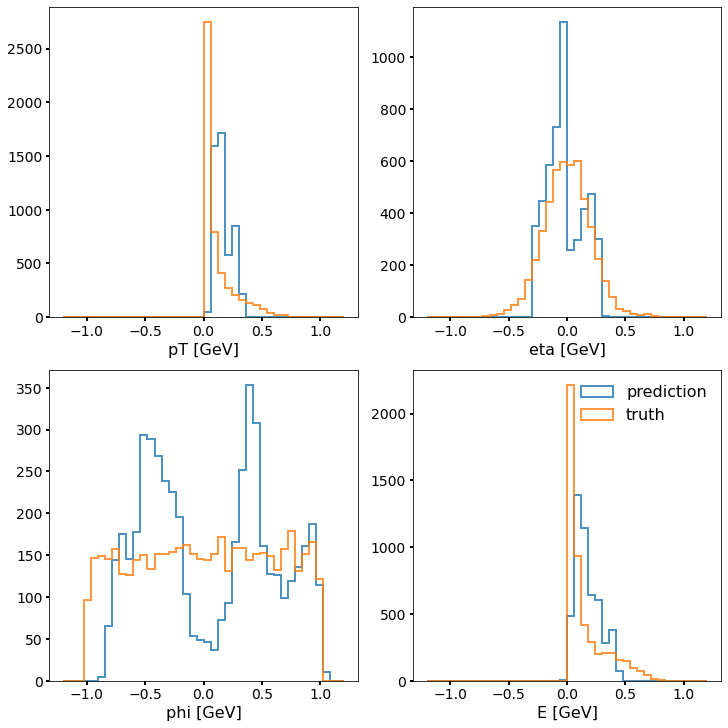

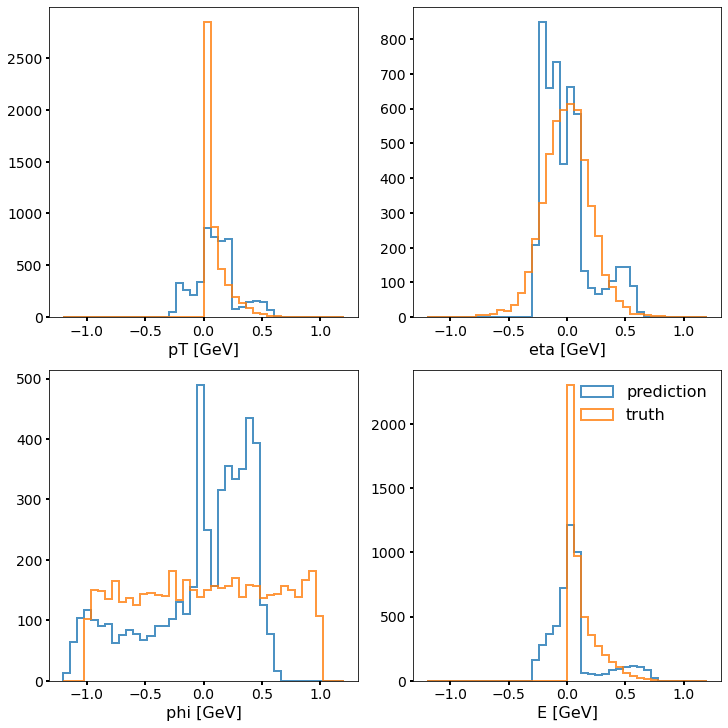

In [13]:
check_file(test_data_name, ngen=1, reuse=False)

In [14]:
import numpy as np

In [15]:
a = np.zeros((10))
b = np.ones((10))

In [16]:
np.stack([a, b], axis=1)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])